<a href="https://colab.research.google.com/github/Oppepper97/AI_assignment/blob/main/AI_Draft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Predicting the FIFA 2022 World Cup**

Welcome to this Jupyter Notebook for the AI Assignment of Pepijn van Vugt (1735664).

In this Jupyter Notebook we will be building a neural network to predict the outcomes of the 2022 FIFA World Cup (WC). This is a highly anticipated event took  take place in Qatar from November 21st to December 18th, 2022, and will feature 32 national teams competing for the trophy.

Predicting the outcomes of sports events is a challenging task, as it involves modeling the performance of teams and players, as well as accounting for various factors such as injuries, form, tactics, and even luck. However, machine learning techniques, and particularly deep learning models, have shown great potential in this domain, and have been used to predict the outcomes of various competitions, including soccer matches.

In this notebook, we will start by exploring the data that we will use to train our model. This will include information about the teams, the goals scored and conceded by all the participating teams, and the matches they have played. We will then pre-process and clean the data, and finally, we will build and train a neural network to make predictions.


# Gathering the data through scraping

In [2]:
# Firstly, I import the right packages to scrape all the World Cup matches.
import pandas as pd
from bs4 import BeautifulSoup
import requests

The following code is from:

Andrade, F. (2022a, November 12). Web Scraping Football Matches From The World Cups 1930 to 2022 with Python. Medium. https://medium.com/geekculture/web-scraping-football-matches-from-the-world-cups-1930-to-2022-with-python-d2a1d578f034

In [3]:
years = [1930, 1934, 1938, 1950, 1954, 1958, 1962, 1966, 1970, 1974,
         1978, 1982, 1986, 1990, 1994, 1998, 2002, 2006, 2010, 2014,
         2018]


def get_matches(year):
    web = f'https://en.wikipedia.org/wiki/{year}_FIFA_World_Cup'
    response = requests.get(web)
    content = response.text
    soup = BeautifulSoup(content, 'lxml')
    matches = soup.find_all('div', class_='footballbox')

    home = []
    score = []
    away = []

    for match in matches:
        home.append(match.find('th', class_='fhome').get_text())
        score.append(match.find('th', class_='fscore').get_text())
        away.append(match.find('th', class_='faway').get_text())

    dict_football = {'home': home, 'score': score, 'away': away}
    df_football = pd.DataFrame(dict_football)
    df_football['year'] = year
    return df_football


# results: historical data
fifa = [get_matches(year) for year in years]
df_fifa = pd.concat(fifa, ignore_index=True)
df_fifa.to_csv("fifa_worldcup_historical_data.csv", index=False)

# fixture
df_fixture = get_matches(2022)
df_fixture.to_csv('fifa_worldcup_fixture.csv', index=False)

Below you can see a table with matchdata from the first World Cup match between 
France and Mexico in 1930, and the final of the 2018 World Cup between France and Croatia. 

####Note:
For some reason the dataframe shows 601 rows, while it should contain 458 rows. That's why I import the CSV File and will change it into a dataframe.

In [4]:
from google.colab import files
uploaded = files.upload()
# Here I import the dataset with WC matches from 1930 till 2018

Saving fifa_worldcup_matches.csv to fifa_worldcup_matches.csv


In [5]:
df_fifa = pd.read_csv('fifa_worldcup_matches.csv')
print(df_fifa)

           home         score      away  year
0       France            4–1    Mexico  1930
1    Argentina            1–0    France  1930
2        Chile            3–0    Mexico  1930
3        Chile            1–0    France  1930
4    Argentina            6–3    Mexico  1930
..          ...           ...       ...   ...
452     Russia   2–2 (a.e.t.)   Croatia  2018
453     France            1–0   Belgium  2018
454    Croatia   2–1 (a.e.t.)   England  2018
455    Belgium            2–0   England  2018
456     France            4–2   Croatia  2018

[457 rows x 4 columns]


In the following table you can see the matches from the 2022 World Cup. However, the scraped data already includes the score from all the 64 matches played during the WC, because the WC has already been finished when coding this assignment. Predicting won't make sense if I already have the scores, because this will influence the model. So, I'll remove the column 'score' to make the model more accurate based on data which was available before the WC started.

In [6]:
df_fixture = df_fixture.drop('score', axis=1)
df_fixture

,home,away,year
0,Qatar,Ecuador,2022
1,Senegal,Netherlands,2022
2,Qatar,Senegal,2022
3,Netherlands,Ecuador,2022
4,Ecuador,Senegal,2022
...,...,...,...
59,England,France,2022
60,Argentina,Croatia,2022
61,France,Morocco,2022
62,Croatia,Morocco,2022


In [7]:
df_fixture.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   home    64 non-null     object
 1   away    64 non-null     object
 2   year    64 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [8]:
df_fixture.to_csv('fifa_2022worldcup_fixture.csv', index=False)

# Gathering tables

To predict the outcomes of the 2022 WC, I also need to get all the tables from the 2018 WC. I can extract these from the wikipedia website. I used a website called the 'waybackmachine' which takes snapshots of earlier versions of websites. 

I chose this method, because at the moment of doing this assignment,the World Cup has already been played. If I used the current website, all the group tables would've already contained data. In this way I have empty group tables. Otherwise I had to clean all the group tables to get rid of the data and strings inside.

However, the waybackmachine does go offline quite often due to high amounts of requests being sent towards the website.

In [9]:
WC_tables = pd.read_html('https://web.archive.org/web/20221120065417/https://en.wikipedia.org/wiki/2022_FIFA_World_Cup')

Here I will create a loop that iterates over the extracted tables and shows where in the page the table is located:

In [10]:
for i in range(14,70,7):
    print(i)
    df = WC_tables[i]

14
21
28
35
42
49
56
63


To get all the tables, I have to use the new dictionary called 'WC_tables', and use elements such as '0', '1', '2' to find the right element which contain the all the WC groups (Group A until Group H). 
All the group tables occur in ever 7 steps, starting from 14. Which means:

- Group A is in table 14
- Group B is in table 21
- Group C is in table 28
- Group D is in table 35
- Group E is in table 42
- Group F is in table 49
- Group G is in table 56
- Group H is in table 63

In [11]:
WC_tables[14] # This is group A of the World Cup

,Pos,"Team.mw-parser-output .navbar{display:inline;font-size:88%;font-weight:normal}.mw-parser-output .navbar-collapse{float:left;text-align:left}.mw-parser-output .navbar-boxtext{word-spacing:0}.mw-parser-output .navbar ul{display:inline-block;white-space:nowrap;line-height:inherit}.mw-parser-output .navbar-brackets::before{margin-right:-0.125em;content:""[ ""}.mw-parser-output .navbar-brackets::after{margin-left:-0.125em;content:"" ]""}.mw-parser-output .navbar li{word-spacing:-0.125em}.mw-parser-output .navbar a>span,.mw-parser-output .navbar a>abbr{text-decoration:inherit}.mw-parser-output .navbar-mini abbr{font-variant:small-caps;border-bottom:none;text-decoration:none;cursor:inherit}.mw-parser-output .navbar-ct-full{font-size:114%;margin:0 7em}.mw-parser-output .navbar-ct-mini{font-size:114%;margin:0 4em}vte",Pld,W,D,L,GF,GA,GD,Pts,Qualification
0,1,Qatar (H),0,0,0,0,0,0,0,0,Advance to knockout stage
1,2,Ecuador,0,0,0,0,0,0,0,0,Advance to knockout stage
2,3,Senegal,0,0,0,0,0,0,0,0,NaN
3,4,Netherlands,0,0,0,0,0,0,0,0,NaN


For the following part I will need to import the alphabet to connect the names of the groups (Group A, B etc) to the table numbers (14,21 etc).

In [12]:
from string import ascii_uppercase as alphabet

In [13]:
alphabet

'ABCDEFGHIJKLMNOPQRSTUVWXYZ'

In [14]:
WC_tables = pd.read_html('https://web.archive.org/web/20221120065417/https://en.wikipedia.org/wiki/2022_FIFA_World_Cup')

dict_table = {}
for letter, i in zip(alphabet, range(14,70,7)):
    df = WC_tables[i]
    df.rename(columns={df.columns[1]:'Team'}, inplace=True)
    dict_table[f'Group {letter}'] = df

In [15]:
dict_table.keys()

dict_keys(['Group A', 'Group B', 'Group C', 'Group D', 'Group E', 'Group F', 'Group G', 'Group H'])

Here you can see the final result of the cleaned groups which are lists now. 

In [16]:
dict_table['Group A']

,Pos,Team,Pld,W,D,L,GF,GA,GD,Pts,Qualification
0,1,Qatar (H),0,0,0,0,0,0,0,0,Advance to knockout stage
1,2,Ecuador,0,0,0,0,0,0,0,0,Advance to knockout stage
2,3,Senegal,0,0,0,0,0,0,0,0,NaN
3,4,Netherlands,0,0,0,0,0,0,0,0,NaN


In [17]:
dict_table['Group B']

,Pos,Team,Pld,W,D,L,GF,GA,GD,Pts,Qualification
0,1,England,0,0,0,0,0,0,0,0,Advance to knockout stage
1,2,Iran,0,0,0,0,0,0,0,0,Advance to knockout stage
2,3,United States,0,0,0,0,0,0,0,0,NaN
3,4,Wales,0,0,0,0,0,0,0,0,NaN


# Cleaning
The CSV Files I have saved have some inconsistencies because they were scraped from Wikipedia. If I look at the CSV File in Excel, I can see that the 1970 World Cup only has only 7 stored matches. That it's not correct. I downloaded the missing dataset from [this](https://github.com/ifrankandrade/fifa-world-cup-2022-prediction/blob/main/data/fifa_worldcup_missing_data.csv) github page.

For this I need to upload the file to Google Colab through the import files function of Google Colab.


In [18]:
from google.colab import files
uploaded = files.upload()
# Here I import the 'fifa world cup missing dataset

Saving fifa_missing_data.csv to fifa_missing_data.csv


In [19]:
import pandas as pd

In [20]:
df_missing_data = pd.read_csv('fifa_missing_data.csv')
print(df_missing_data)

              home score           away  year
0          Mexico    0–0   Soviet Union  1970
1         Belgium    3–0    El Salvador  1970
2    Soviet Union    4–1        Belgium  1970
3          Mexico    4–0    El Salvador  1970
4    Soviet Union    2–0    El Salvador  1970
..             ...   ...            ...   ...
503         Spain    0–1    Switzerland  2010
504         Chile    1–0    Switzerland  2010
505         Spain    2–0       Honduras  2010
506         Chile    1–2          Spain  2010
507   Switzerland    0–0       Honduras  2010

[508 rows x 4 columns]



I will merge the dataframe with historical data with the missing data dataframe to get a full dataframe that contains all the matches and data from 1930 until 2018. This is needed to calculate the goals scored and goals conceded for each team in all the played World Cups since 1930.

In [21]:
df_missing_data.dropna(inplace=True)
df_fifa_all_worldcup = pd.concat([df_fifa, df_missing_data], ignore_index=True)
df_fifa_all_worldcup.drop_duplicates(inplace=True)
df_fifa_all_worldcup.sort_values('year', inplace=True)
df_fifa_all_worldcup

,home,score,away,year
0,France,4–1,Mexico,1930
17,Uruguay,4–2,Argentina,1930
16,Uruguay,6–1,Yugoslavia,1930
15,Argentina,6–1,United States,1930
14,Paraguay,1–0,Belgium,1930
...,...,...,...,...
419,Brazil,2–0,Costa Rica,2018
420,Serbia,1–2,Switzerland,2018
421,Serbia,0–2,Brazil,2018
408,France,1–0,Peru,2018


In [22]:
from google.colab import files
df_fifa_all_worldcup.to_csv('clean_fifa_worldcup.csv',index=False)

The first World Cup was a small one with only 18 matches. The tournament became more popular and the sport was developing itself more and more. Every edition more countries were participating, and thus more matches were being played. Since 1998 matches are being played. In 2026, 48 different countries will participate in the World Cup, making it the biggest tournament yet.

Here you can see the amount of matches being played per World Cup:

In [23]:
years = [1930, 1934, 1938, 1950, 1954, 1958, 1962, 1966, 1970, 1974,
         1978, 1982, 1986, 1990, 1994, 1998, 2002, 2006, 2010, 2014,
         2018]

for year in years:
    print(year, len(df_fifa_all_worldcup[df_fifa_all_worldcup['year']==year]))

1930 18
1934 17
1938 19
1950 22
1954 26
1958 35
1962 32
1966 32
1970 32
1974 38
1978 38
1982 52
1986 52
1990 52
1994 52
1998 64
2002 64
2006 64
2010 64
2014 64
2018 64


# Calculating the historical results of all the World Cup matches from 1930 till 2018
To predict the outcome of the 2022 World Cup I will have to calculate the strength of all the participating teams. I will do this by calculating the goals scored and goals conceded in a historical way. This will result in historical records up until the time a team will play their next match. I will use the mean to get this record.

Now that the whole df was cleaned. I could take the sum of 'HomeGoals' and 'AwayGoals' and add these to a new column named 'TotalGoals'. After this step I can calculate the historical results and team strength.

In [24]:
# deleting match with walk over
delete_index = df_fifa_all_worldcup[df_fifa_all_worldcup['home'].str.contains('Sweden') &
                                    df_fifa_all_worldcup['away'].str.contains('Austria')].index

df_fifa_all_worldcup.drop(index=delete_index, inplace=True)

# cleanning score and home/away columns
df_fifa_all_worldcup['score'] = df_fifa_all_worldcup['score'].str.replace('[^\d–]', '', regex=True)
df_fifa_all_worldcup['home'] = df_fifa_all_worldcup['home'].str.strip() # clean blank spaces: Yugoslavia twice
df_fifa_all_worldcup['away'] = df_fifa_all_worldcup['away'].str.strip()

# splitting score columns into home and away goals and dropping score column
df_fifa_all_worldcup[['HomeGoals', 'AwayGoals']] = df_fifa_all_worldcup['score'].str.split('–', expand=True)
df_fifa_all_worldcup.drop('score', axis=1, inplace=True)

# renaming columns and changing data types
df_fifa_all_worldcup.rename(columns={'home': 'HomeTeam', 'away': 'AwayTeam', 
                                   'year':'Year'}, inplace=True)
df_fifa_all_worldcup = df_fifa_all_worldcup.astype({'HomeGoals': int, 'AwayGoals':int, 'Year': int})

# creating new column "totalgoals"
df_fifa_all_worldcup['TotalGoals'] = df_fifa_all_worldcup['HomeGoals'] + df_fifa_all_worldcup['AwayGoals']
df_fifa_all_worldcup

,HomeTeam,AwayTeam,Year,HomeGoals,AwayGoals,TotalGoals
0,France,Mexico,1930,4,1,5
17,Uruguay,Argentina,1930,4,2,6
16,Uruguay,Yugoslavia,1930,6,1,7
15,Argentina,United States,1930,6,1,7
14,Paraguay,Belgium,1930,1,0,1
...,...,...,...,...,...,...
419,Brazil,Costa Rica,2018,2,0,2
420,Serbia,Switzerland,2018,1,2,3
421,Serbia,Brazil,2018,0,2,2
408,France,Peru,2018,1,0,1


In [25]:
df_worldcup = df_fifa_all_worldcup.rename(columns={'score': 'result'})
df_worldcup

,HomeTeam,AwayTeam,Year,HomeGoals,AwayGoals,TotalGoals
0,France,Mexico,1930,4,1,5
17,Uruguay,Argentina,1930,4,2,6
16,Uruguay,Yugoslavia,1930,6,1,7
15,Argentina,United States,1930,6,1,7
14,Paraguay,Belgium,1930,1,0,1
...,...,...,...,...,...,...
419,Brazil,Costa Rica,2018,2,0,2
420,Serbia,Switzerland,2018,1,2,3
421,Serbia,Brazil,2018,0,2,2
408,France,Peru,2018,1,0,1


In [26]:
df_worldcup

,HomeTeam,AwayTeam,Year,HomeGoals,AwayGoals,TotalGoals
0,France,Mexico,1930,4,1,5
17,Uruguay,Argentina,1930,4,2,6
16,Uruguay,Yugoslavia,1930,6,1,7
15,Argentina,United States,1930,6,1,7
14,Paraguay,Belgium,1930,1,0,1
...,...,...,...,...,...,...
419,Brazil,Costa Rica,2018,2,0,2
420,Serbia,Switzerland,2018,1,2,3
421,Serbia,Brazil,2018,0,2,2
408,France,Peru,2018,1,0,1


To rename the columns and calculate the mean goals scored and conceded later, I need to split the dataframe into a home and away dateframe.

In [27]:
df_home = df_worldcup[['Year','HomeTeam', 'HomeGoals', 'AwayGoals']]
df_away = df_worldcup[['Year','AwayTeam', 'HomeGoals', 'AwayGoals']]

In [28]:
df_home

,Year,HomeTeam,HomeGoals,AwayGoals
0,1930,France,4,1
17,1930,Uruguay,4,2
16,1930,Uruguay,6,1
15,1930,Argentina,6,1
14,1930,Paraguay,1,0
...,...,...,...,...
419,2018,Brazil,2,0
420,2018,Serbia,1,2
421,2018,Serbia,0,2
408,2018,France,1,0


In [29]:
df_away

,Year,AwayTeam,HomeGoals,AwayGoals
0,1930,Mexico,4,1
17,1930,Argentina,4,2
16,1930,Yugoslavia,6,1
15,1930,United States,6,1
14,1930,Belgium,1,0
...,...,...,...,...
419,2018,Costa Rica,2,0
420,2018,Switzerland,1,2
421,2018,Brazil,0,2
408,2018,Peru,1,0


Changing the HomeGoals and AwayGoals columns into GoalsScored and Goalsconceded

In [30]:
df_home = df_home.rename(columns={'HomeGoals': 'HomeGoalsScored', 'AwayGoals': 'HomeGoalsConceded'})
df_away = df_away.rename(columns={'HomeGoals': 'AwayGoalsConceded', 'AwayGoals': 'AwayGoalsScored'})
df_home

,Year,HomeTeam,HomeGoalsScored,HomeGoalsConceded
0,1930,France,4,1
17,1930,Uruguay,4,2
16,1930,Uruguay,6,1
15,1930,Argentina,6,1
14,1930,Paraguay,1,0
...,...,...,...,...
419,2018,Brazil,2,0
420,2018,Serbia,1,2
421,2018,Serbia,0,2
408,2018,France,1,0


Dropping the column 'Year' in df_away, otherwise I'll have 2 columns for Year when concatenating

In [31]:
df_away.drop('Year', axis=1, inplace=True)
df_away

,AwayTeam,AwayGoalsConceded,AwayGoalsScored
0,Mexico,4,1
17,Argentina,4,2
16,Yugoslavia,6,1
15,United States,6,1
14,Belgium,1,0
...,...,...,...
419,Costa Rica,2,0
420,Switzerland,1,2
421,Brazil,0,2
408,Peru,1,0


In [32]:
df_worldcup = pd.concat([df_home, df_away], axis=1)
df_worldcup

,Year,HomeTeam,HomeGoalsScored,HomeGoalsConceded,AwayTeam,AwayGoalsConceded,AwayGoalsScored
0,1930,France,4,1,Mexico,4,1
17,1930,Uruguay,4,2,Argentina,4,2
16,1930,Uruguay,6,1,Yugoslavia,6,1
15,1930,Argentina,6,1,United States,6,1
14,1930,Paraguay,1,0,Belgium,1,0
...,...,...,...,...,...,...,...
419,2018,Brazil,2,0,Costa Rica,2,0
420,2018,Serbia,1,2,Switzerland,1,2
421,2018,Serbia,0,2,Brazil,0,2
408,2018,France,1,0,Peru,1,0


I will also create a function that determines the outcome of the match based on the perspective of the home team. The result will either be a win, a draw or a loss for the hometeam. This will be added into a new column in the dataframe.

In [33]:
def determine_outcome(row):
    if row['HomeGoalsScored'] > row['AwayGoalsScored']:
        return 'win'
    elif row['HomeGoalsScored'] < row['AwayGoalsScored']:
        return 'lose'
    else:
        return 'draw'

df_worldcup['Outcome'] = df_worldcup.apply(lambda row: determine_outcome(row), axis=1)
df_worldcup

,Year,HomeTeam,HomeGoalsScored,HomeGoalsConceded,AwayTeam,AwayGoalsConceded,AwayGoalsScored,Outcome
0,1930,France,4,1,Mexico,4,1,win
17,1930,Uruguay,4,2,Argentina,4,2,win
16,1930,Uruguay,6,1,Yugoslavia,6,1,win
15,1930,Argentina,6,1,United States,6,1,win
14,1930,Paraguay,1,0,Belgium,1,0,win
...,...,...,...,...,...,...,...,...
419,2018,Brazil,2,0,Costa Rica,2,0,win
420,2018,Serbia,1,2,Switzerland,1,2,lose
421,2018,Serbia,0,2,Brazil,0,2,lose
408,2018,France,1,0,Peru,1,0,win


In [34]:
df_worldcup.to_csv('full_wc_matches.csv')

# Calculating the mean goals scored and conceded per team up until the next match of the team.

The first part of the code generates four new columns in 'df_worldcup'. The columns are called 'AvgGoalsScoredHome', 'AvgGoalsConcededHome', 'AvgGoalsScoredAway', and 'AvgGoalsConcededAway'.

In [35]:
df_worldcup["AvgGoalsScoredHome"] = pd.Series(dtype="object")
df_worldcup["AvgGoalsConcededHome"] = pd.Series(dtype="object")
df_worldcup["AvgGoalsScoredAway"] = pd.Series(dtype="object")
df_worldcup["AvgGoalsConcededAway"] = pd.Series(dtype="object")

In the next cell, a function with two arguments 'team' and 'matches', calculates the mean of the goals scored and conceded by a team when it played as the home and away team. After that the function concatenates these two series to extract the goals conceded and also concatenates these two series. At the end the function calculates the mean of both concatenated serieus and returns them.

In [36]:
def get_goals(team, matches):
    goals_scored1 = matches[matches["HomeTeam"] == team]["HomeGoalsScored"]
    goals_scored2 = matches[matches["AwayTeam"] == team]["AwayGoalsScored"]
    goals_conceded1 = matches[matches["HomeTeam"] == team]["HomeGoalsConceded"]
    goals_conceded2 = matches[matches["AwayTeam"] == team]["AwayGoalsConceded"]
    goals_scored = pd.concat([goals_scored1, goals_scored2])
    goals_conceded = pd.concat([goals_conceded1, goals_conceded2])
    return goals_scored.mean(), goals_conceded.mean()

Finally a for loop iterates through the rows of df_worldcup. For each iteration, it assign the values of the 'HomeTeam' and 'AwayTeam' for the currect row to the variables 'team_home' and 'team_away'.
It then uses 'iloc' to select all rows up to the current row and assigns it to the variable 'df_before'. Then it calls the 'get_goals' function from the cell above, by passing 'team_home' and 'df_before which return a tuple of two values, which are assigned to 'goals_home'. It does the same in the next line, but then for 'team_away' to 'goals_away'.

Finally it uses the 'loc' function to add al these calculated values to the corresponding columns.


In [37]:
for i in range(len(df_worldcup)):
    team_home = df_worldcup.iloc[i, df_worldcup.columns.get_loc('HomeTeam')]
    team_away = df_worldcup.iloc[i, df_worldcup.columns.get_loc('AwayTeam')]
    df_before = df_worldcup.iloc[:i+1, :]
    goals_home = get_goals(team_home, df_before)
    goals_away = get_goals(team_away, df_before)
    df_worldcup.loc[i,"AvgGoalsScoredHome"] = goals_home[0] 
    df_worldcup.loc[i,"AvgGoalsConcededHome"] = goals_home[1]
    df_worldcup.loc[i,"AvgGoalsScoredAway"] = goals_away[0] 
    df_worldcup.loc[i,"AvgGoalsConcededAway"] = goals_away[1]
df_worldcup

,Year,HomeTeam,HomeGoalsScored,HomeGoalsConceded,AwayTeam,AwayGoalsConceded,AwayGoalsScored,Outcome,AvgGoalsScoredHome,AvgGoalsConcededHome,AvgGoalsScoredAway,AvgGoalsConcededAway
0,1930.0,France,4.0,1.0,Mexico,4.0,1.0,win,4.0,1.0,1.0,4.0
17,1930.0,Uruguay,4.0,2.0,Argentina,4.0,2.0,win,2.5,1.0,0.0,4.0
16,1930.0,Uruguay,6.0,1.0,Yugoslavia,6.0,1.0,win,3.6,1.8,1.333333,1.0
15,1930.0,Argentina,6.0,1.0,United States,6.0,1.0,win,1.666667,1.0,1.333333,4.333333
14,1930.0,Paraguay,1.0,0.0,Belgium,1.0,0.0,win,1.0,1.5,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
420,2018.0,Serbia,1.0,2.0,Switzerland,1.0,2.0,lose,1.68,1.06,1.685714,1.4
421,2018.0,Serbia,0.0,2.0,Brazil,0.0,2.0,lose,0.0,0.5,1.333333,1.888889
408,2018.0,France,1.0,0.0,Peru,1.0,0.0,win,3.0,2.0,1.787879,1.424242
450,2018.0,Brazil,1.0,2.0,Belgium,1.0,2.0,lose,0.25,0.5,0.666667,1.666667


There is one row with the match between Switzerland and Honduras during the 2010 World Cup that doesn't have the Avg in the column. [The match](https://www.google.com/search?hl=nl&q=Switzerland%20Honduras%202010%20world%20cup#sie=m;/g/11ggr86w2m;2;/m/030q7;dt;fp;1;;;) finished in 0-0.
Luckily, this means that I can fill these columns with 0 and add it back to the df.

In [38]:
df_worldcup.loc[900, ['AvgGoalsScoredHome','AvgGoalsConcededHome','AvgGoalsScoredAway','AvgGoalsConcededAway']] = df_worldcup.loc[900, ['AvgGoalsScoredHome','AvgGoalsConcededHome','AvgGoalsScoredAway','AvgGoalsConcededAway']].fillna(0)


In [39]:
df_worldcup = df_worldcup.drop(df_worldcup.index[-1])
df_worldcup

,Year,HomeTeam,HomeGoalsScored,HomeGoalsConceded,AwayTeam,AwayGoalsConceded,AwayGoalsScored,Outcome,AvgGoalsScoredHome,AvgGoalsConcededHome,AvgGoalsScoredAway,AvgGoalsConcededAway
0,1930.0,France,4.0,1.0,Mexico,4.0,1.0,win,4.0,1.0,1.0,4.0
17,1930.0,Uruguay,4.0,2.0,Argentina,4.0,2.0,win,2.5,1.0,0.0,4.0
16,1930.0,Uruguay,6.0,1.0,Yugoslavia,6.0,1.0,win,3.6,1.8,1.333333,1.0
15,1930.0,Argentina,6.0,1.0,United States,6.0,1.0,win,1.666667,1.0,1.333333,4.333333
14,1930.0,Paraguay,1.0,0.0,Belgium,1.0,0.0,win,1.0,1.5,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
419,2018.0,Brazil,2.0,0.0,Costa Rica,2.0,0.0,win,2.051724,1.258621,1.351351,0.945946
420,2018.0,Serbia,1.0,2.0,Switzerland,1.0,2.0,lose,1.68,1.06,1.685714,1.4
421,2018.0,Serbia,0.0,2.0,Brazil,0.0,2.0,lose,0.0,0.5,1.333333,1.888889
408,2018.0,France,1.0,0.0,Peru,1.0,0.0,win,3.0,2.0,1.787879,1.424242


In [40]:
df_worldcup = df_worldcup.round(2)
df_worldcup

,Year,HomeTeam,HomeGoalsScored,HomeGoalsConceded,AwayTeam,AwayGoalsConceded,AwayGoalsScored,Outcome,AvgGoalsScoredHome,AvgGoalsConcededHome,AvgGoalsScoredAway,AvgGoalsConcededAway
0,1930.0,France,4.0,1.0,Mexico,4.0,1.0,win,4.0,1.0,1.0,4.0
17,1930.0,Uruguay,4.0,2.0,Argentina,4.0,2.0,win,2.5,1.0,0.0,4.0
16,1930.0,Uruguay,6.0,1.0,Yugoslavia,6.0,1.0,win,3.6,1.8,1.333333,1.0
15,1930.0,Argentina,6.0,1.0,United States,6.0,1.0,win,1.666667,1.0,1.333333,4.333333
14,1930.0,Paraguay,1.0,0.0,Belgium,1.0,0.0,win,1.0,1.5,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
419,2018.0,Brazil,2.0,0.0,Costa Rica,2.0,0.0,win,2.051724,1.258621,1.351351,0.945946
420,2018.0,Serbia,1.0,2.0,Switzerland,1.0,2.0,lose,1.68,1.06,1.685714,1.4
421,2018.0,Serbia,0.0,2.0,Brazil,0.0,2.0,lose,0.0,0.5,1.333333,1.888889
408,2018.0,France,1.0,0.0,Peru,1.0,0.0,win,3.0,2.0,1.787879,1.424242


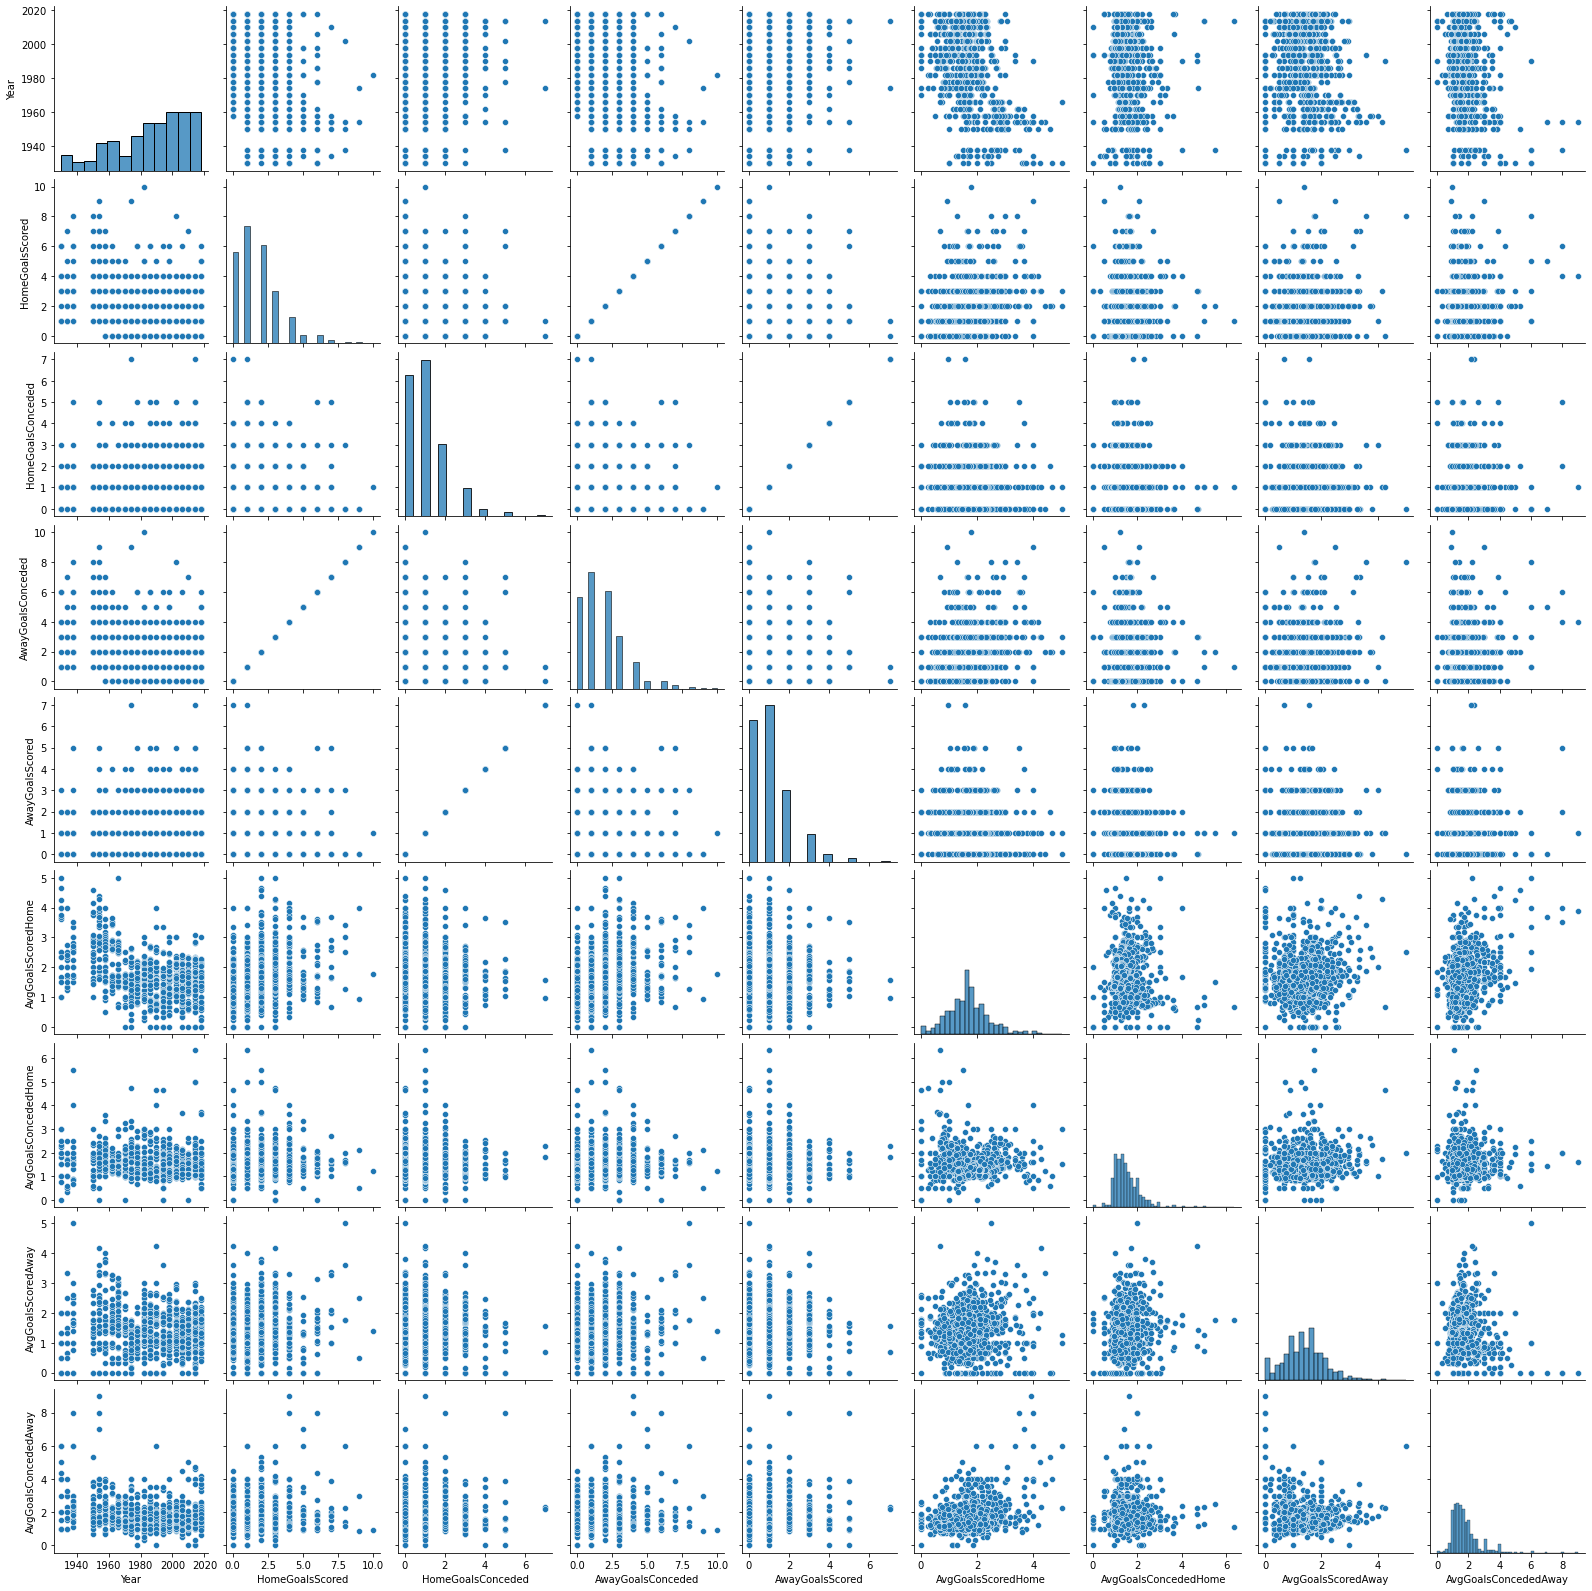

In [41]:
import seaborn as sns
sns.pairplot(data=df_worldcup)

When looking at the scatterplots in which the datapoints are distributed vertically, it can be seen that there is a strong correlation between the variables. Which makes sense, because AvgGoalsConceded away are influenced by HomeGoalsScored for example.

The same is for scatterplots in wich the AwayGoalsScored and HomeGoalsConceded are visualized. 

When looking at all the graphs, it can be concluded that there are strong linear relationships between the variables.

In [42]:
df_worldcup.to_csv('WC_FULL.csv')

# Weighing matches

It is strange to weigh matches from 1930 in the same way as matches in 2018. The game evolves everyday, but with recent technology players are tactically and technically more defined. I'll try to experiment with a formula that will weigh recent matches more heavy than matches from 1930. After that I can start training the model.

# Training the model #1

Now that I have my data, I will start with training my model. I will use classification in order to predict the results of the Fifa 2022 World Cup. Classification is a useful approach, because it can be used to predict categorical outcomes (win, lose or draw). I will use the average goals scored and conceded for this.

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense
import pandas as pd

Random_state is used to set a seed for the random number generator, this will ensure that the same data is split every time I run the code.


In [44]:
from sklearn.model_selection import train_test_split
X = df_worldcup.drop(['Outcome'], axis=1)
y = df_worldcup['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [45]:
df = pd.concat([X_train, X_test], axis=0)
df = pd.get_dummies(df)
X_train, X_test = df.iloc[:len(X_train)], df.iloc[len(X_train):]

The categorical columns are encoded with 'get_dummies'.

In [46]:
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

Encoding with 'LabelEncoder'

In [47]:
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

Creating an instance of the Sequential class: This is the first step in creating a neural network in Keras. We create an instance of the Sequential class, which allows me to create a linear stack of layers

In [48]:
model = Sequential()

Adding the input layer and the first hidden layer: Using the add() method to add a hidden layer to the model. The first parameter is the number of nodes, or units, in the layer. The activation parameter is the activation function for the layer. The input_dim parameter is used to specify the number of input features.

In [49]:
model.add(Dense(units=3, activation='sigmoid', input_dim=X_train.shape[1]))

Adding the output layer: Using the add() method to add the output layer to the model. The number of units should be equal to the number of classes in the target variable. In this case, since it's binary classification, we have only one output unit.

In [50]:
model.add(Dense(units=3, activation='sigmoid'))

Compiling the model: Using the compile() method to specify the loss function, optimizer, and evaluation metric for the model. The loss function is the function that will be minimized during training, optimizer is the algorithm used to update the weights and the evaluation metric is used to evaluate the model's performance.

In [51]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Training the model: Using the fit() method to train the model on the training data. We specify the number of epochs and the batch size. The epochs parameter is the number of times the model will cycle through the data, and the batch size is the number of samples per gradient update.

In [74]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
23/23 [==============================] - 0s 3ms/step - loss: 0.9355 - accuracy: 0.5653
Epoch 2/100
23/23 [==============================] - 0s 3ms/step - loss: 0.9380 - accuracy: 0.5667
Epoch 3/100
23/23 [==============================] - 0s 3ms/step - loss: 0.9354 - accuracy: 0.5653
Epoch 4/100
23/23 [==============================] - 0s 3ms/step - loss: 0.9350 - accuracy: 0.5625
Epoch 5/100
23/23 [==============================] - 0s 3ms/step - loss: 0.9347 - accuracy: 0.5694
Epoch 6/100
23/23 [==============================] - 0s 3ms/step - loss: 0.9344 - accuracy: 0.5653
Epoch 7/100
23/23 [==============================] - 0s 3ms/step - loss: 0.9348 - accuracy: 0.5667
Epoch 8/100
23/23 [==============================] - 0s 3ms/step - loss: 0.9349 - accuracy: 0.5667
Epoch 9/100
23/23 [==============================] - 0s 3ms/step - loss: 0.9343 - accuracy: 0.5736
Epoch 10/100
23/23 [==============================] - 0s 3ms/step - loss: 0.9338 - accuracy: 0.5653
Epoch 11/

In [75]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print('Test accuracy:', test_acc)

Test accuracy: 0.5055555701255798


As you can see, the loss is decreasing over time and the accuracy stays the same with a total accuracy of 50%. I will visualize this and will try to train the model in the next section with different features.


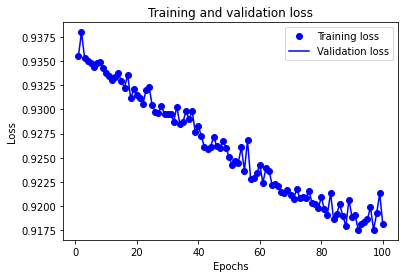

In [76]:
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

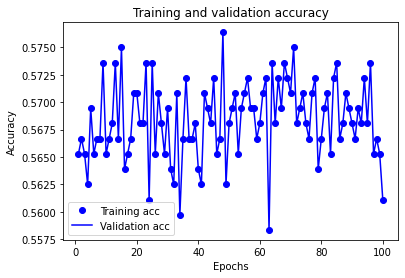

In [77]:
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

When analyzing the results, I've found out why the results are bad. I've been using binary classification, but I should use multiclass classification because I'm using 'win', 'draw' or 'lose' as possible outcomes. Hence, multiclass.
I'll do this in the following chapter.

#Training the model #2

In [53]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
import pandas as pd

Extracting the columns from the dataset. These will be used as input. The output column will contain the data from 'Outcome' from the same dataset.
Then the input features and output variables are splitted into training and test sets. 80% of the data is being used for training and 20% for testing.

In [54]:
X = df_worldcup[['AvgGoalsScoredHome', 'AvgGoalsConcededHome', 'AvgGoalsScoredAway', 'AvgGoalsConcededAway',]] 
y = df_worldcup['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Converting the the types into float32.

In [55]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

Converting the output variable into a format that can be used in a multi-class classification problem. The "LabelEncoder" class is used to encode the string labels as integers and the "to_categorical" function is used to convert the integers to a binary class matrix.

In [56]:
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

Creating an object of the Sequential class and the next two lines are adding layers to the network. The first layer has 10 units, uses the 'relu' activation function. 
The second layer has 3 units and uses the 'softmax' activation function.

In [57]:
input_shape = 4

# Define the model
model = Sequential()

# Add the input layer and the first hidden layer
model.add(Dense(10, input_dim=input_shape, activation='relu'))

# Add additional hidden layers
model.add(Dense(8, activation='relu'))
model.add(Dense(6, activation='relu'))

# Add the output layer
model.add(Dense(3, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Compiling the neural network.

In [58]:
#from tensorflow.keras.optimizers.schedules import ExponentialDecay
#from tensorflow.keras.optimizers import Adam

#from tensorflow.keras.optimizers import SGD

#lr_schedule = ExponentialDecay(initial_learning_rate=0.05, decay_steps=10000, decay_rate=0.96)
#optimizer = SGD(learning_rate=lr_schedule)

#model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])


In [59]:
model2 = model.fit(X_train, y_train, epochs=100,validation_data=[X_test, y_test], batch_size=32)

Epoch 1/100
23/23 [==============================] - 3s 11ms/step - loss: 1.2977 - accuracy: 0.2153 - val_loss: 1.1848 - val_accuracy: 0.2778
Epoch 2/100
23/23 [==============================] - 0s 4ms/step - loss: 1.1708 - accuracy: 0.2403 - val_loss: 1.1150 - val_accuracy: 0.3278
Epoch 3/100
23/23 [==============================] - 0s 4ms/step - loss: 1.1081 - accuracy: 0.3333 - val_loss: 1.0852 - val_accuracy: 0.4167
Epoch 4/100
23/23 [==============================] - 0s 4ms/step - loss: 1.0776 - accuracy: 0.4958 - val_loss: 1.0676 - val_accuracy: 0.5056
Epoch 5/100
23/23 [==============================] - 0s 4ms/step - loss: 1.0624 - accuracy: 0.5403 - val_loss: 1.0560 - val_accuracy: 0.5111
Epoch 6/100
23/23 [==============================] - 0s 4ms/step - loss: 1.0490 - accuracy: 0.5486 - val_loss: 1.0484 - val_accuracy: 0.5000
Epoch 7/100
23/23 [==============================] - 0s 4ms/step - loss: 1.0268 - accuracy: 0.5500 - val_loss: 1.0370 - val_accuracy: 0.5000
Epoch 8/100


As you can see, with using multiclass classification based on multiple columns from the dataframe, the accuracy is twice as good as before, with around 50.0% to 55.0% accuracy.
However, around 50% accuracy is not very good. The model is only a bit better than random guessing. I tried to play around with the parameters, the activation and the learning schedule. However, due to time restraints no progress was made in making the model more accurate.

This probably has to do with the fact that the dataset doesn't include enough data. After this assignment, I will try to weigh recent matches heavier than matches played before 1980.


In [60]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print('Test accuracy:', test_acc)

Test accuracy: 0.5


In [61]:
precision = model.evaluate(X_test, y_test, return_dict=True)

6/6 [==============================] - 0s 3ms/step - loss: 1.0632 - accuracy: 0.5000


The loss value is around 1.005 is indicating that the model's predictions deviate a lot from the true values

In [62]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 10)                50        
                                                                 
 dense_3 (Dense)             (None, 8)                 88        
                                                                 
 dense_4 (Dense)             (None, 6)                 54        
                                                                 
 dense_5 (Dense)             (None, 3)                 21        
                                                                 
Total params: 213
Trainable params: 213
Non-trainable params: 0
_________________________________________________________________


# Predicting the FIFA 2022 World Cup
To predict the results of the FIFA 2022 World Cup, I need the following:
- Trained Model,
- Dataset 'WC_FULL',
- Dataset with World Cup 2022 fixtures,
- World Cup 2022 Group Tables.

In [63]:
df_WC = pd.read_csv('WC_FULL.csv')
df_WC

,Unnamed: 0,Year,HomeTeam,HomeGoalsScored,HomeGoalsConceded,AwayTeam,AwayGoalsConceded,AwayGoalsScored,Outcome,AvgGoalsScoredHome,AvgGoalsConcededHome,AvgGoalsScoredAway,AvgGoalsConcededAway
0,0,1930.0,France,4.0,1.0,Mexico,4.0,1.0,win,4.000000,1.000000,1.000000,4.000000
1,17,1930.0,Uruguay,4.0,2.0,Argentina,4.0,2.0,win,2.500000,1.000000,0.000000,4.000000
2,16,1930.0,Uruguay,6.0,1.0,Yugoslavia,6.0,1.0,win,3.600000,1.800000,1.333333,1.000000
3,15,1930.0,Argentina,6.0,1.0,United States,6.0,1.0,win,1.666667,1.000000,1.333333,4.333333
4,14,1930.0,Paraguay,1.0,0.0,Belgium,1.0,0.0,win,1.000000,1.500000,2.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,419,2018.0,Brazil,2.0,0.0,Costa Rica,2.0,0.0,win,2.051724,1.258621,1.351351,0.945946
896,420,2018.0,Serbia,1.0,2.0,Switzerland,1.0,2.0,lose,1.680000,1.060000,1.685714,1.400000
897,421,2018.0,Serbia,0.0,2.0,Brazil,0.0,2.0,lose,0.000000,0.500000,1.333333,1.888889
898,408,2018.0,France,1.0,0.0,Peru,1.0,0.0,win,3.000000,2.000000,1.787879,1.424242


In [64]:
df_fixture

,home,away,year
0,Qatar,Ecuador,2022
1,Senegal,Netherlands,2022
2,Qatar,Senegal,2022
3,Netherlands,Ecuador,2022
4,Ecuador,Senegal,2022
...,...,...,...
59,England,France,2022
60,Argentina,Croatia,2022
61,France,Morocco,2022
62,Croatia,Morocco,2022


In [65]:
df_fixture['home'].replace({'Qatar\xa0': 'Qatar'}, inplace=True)

In [66]:
df_fixture['away'].replace({'Qatar\xa0': 'Qatar'}, inplace=True)

In [67]:
dict_table

{'Group A':    Pos         Team  Pld  W  D  L  GF  GA  GD  Pts              Qualification
 0    1    Qatar (H)    0  0  0  0   0   0   0    0  Advance to knockout stage
 1    2      Ecuador    0  0  0  0   0   0   0    0  Advance to knockout stage
 2    3      Senegal    0  0  0  0   0   0   0    0                        NaN
 3    4  Netherlands    0  0  0  0   0   0   0    0                        NaN,
 'Group B':    Pos           Team  Pld  W  D  L  GF  GA  GD  Pts  \
 0    1        England    0  0  0  0   0   0   0    0   
 1    2           Iran    0  0  0  0   0   0   0    0   
 2    3  United States    0  0  0  0   0   0   0    0   
 3    4          Wales    0  0  0  0   0   0   0    0   
 
                Qualification  
 0  Advance to knockout stage  
 1  Advance to knockout stage  
 2                        NaN  
 3                        NaN  ,
 'Group C':    Pos          Team  Pld  W  D  L  GF  GA  GD  Pts              Qualification
 0    1     Argentina    0  0  0  0   0   0

Firstly I have to predict the winners during the groupstages. The first and second place will progress to the round of sixteen.
I won't predict the points in the groups, but I will predict the winners and based on the matches played in the groupstage (dict_table), the results will show which teams will progress and which teams will be eliminated.

In [68]:
import pickle
from scipy.stats import poisson
import tensorflow as tf
import numpy as np

In [69]:
df_home = df_WC[['HomeTeam', 'AvgGoalsScoredHome', 'AvgGoalsConcededHome']]
df_away = df_WC[['AwayTeam', 'AvgGoalsScoredAway', 'AvgGoalsConcededAway']]

df_home = df_home.rename(columns={'HomeTeam':'Team'})
df_away = df_away.rename(columns={'AwayTeam':'Team'})

df_WCteam_strength = pd.concat([df_home, df_away], ignore_index=True)
df_WCteam_strength

,Team,AvgGoalsScoredHome,AvgGoalsConcededHome,AvgGoalsScoredAway,AvgGoalsConcededAway
0,France,4.000000,1.0,NaN,NaN
1,Uruguay,2.500000,1.0,NaN,NaN
2,Uruguay,3.600000,1.8,NaN,NaN
3,Argentina,1.666667,1.0,NaN,NaN
4,Paraguay,1.000000,1.5,NaN,NaN
...,...,...,...,...,...
1795,Costa Rica,NaN,NaN,1.351351,0.945946
1796,Switzerland,NaN,NaN,1.685714,1.400000
1797,Brazil,NaN,NaN,1.333333,1.888889
1798,Peru,NaN,NaN,1.787879,1.424242


Function that uses the multiclass classification model and predicts the results from the 2022 WC from the df_WCteam_stength and calculates the winner from the matches that are in df_fixture. First the group stage, which are the first 48 matches.

In [70]:
def predict_points(home, away):
    home = home.title()
    away = away.title()
    if home in df_WC['HomeTeam'].values and away in df_WC['AwayTeam'].values:
        # goals_scored * goals_conceded
        lamb_home = df_WC.at[home,'AvgGoalsScoredHome'] * df_WC.at[away,'AvgGoalsConcededAway']
        lamb_away = df_WC.at[away,'AvgGoalsConcededHome'] * df_WC.at[home,'AvgGoalsScoredAway']
        prob_home, prob_away, prob_draw = 0, 0, 0
        for x in range(0,11): #number of goals home team
            for y in range(0, 11): #number of goals away team
                p = poisson.pmf(x, lamb_home) * poisson.pmf(y, lamb_away)
                if x == y:
                    prob_draw += p
                elif x > y:
                    prob_home += p
                else:
                    prob_away += p
        
        points_home = 3 * prob_home + prob_draw
        points_away = 3 * prob_away + prob_draw
        return (points_home, points_away)
    else:
        return (0, 0)


In [71]:
df_fixture_group = df_fixture[:48].copy()
df_fixture_knockout = df_fixture[48:56].copy()
df_fixture_quarter = df_fixture[56:60].copy()
df_fixture_semi = df_fixture[60:62].copy()
df_fixture_final = df_fixture[63:].copy()

In [72]:
for group in dict_table:
    teams_in_group = dict_table[group]['Team'].values
    df_fixture_group_6 = df_fixture_group[df_fixture_group['home'].isin(teams_in_group)]
    for index, row in df_fixture_group_6.iterrows():
        home, away = row['home'], row['away']
        points = predict_points(home, away)
        home_points = points[0]
        away_points = points[1]
        dict_table[group].loc[dict_table[group]['Team'] == home, 'Pts'] += home_points
        dict_table[group].loc[dict_table[group]['Team'] == away, 'Pts'] += away_points

    dict_table[group] = dict_table[group].sort_values('Pts', ascending=False).reset_index()
    dict_table[group] = dict_table[group][['Team', 'Pts']]
    dict_table[group] = dict_table[group].round(0)


In [73]:
dict_table['Group A']

,Team,Pts
0,Qatar (H),0
1,Ecuador,0
2,Senegal,0
3,Netherlands,0
